# Housing Prices: Advanced Regression


In [14]:
import random
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
def encode_features(df_train, df_test):
    '''
    Takes columns whose values are strings (objects)
    and categorizes them into discrete numbers.
    This makes it feasible to use regression
    '''
    features = list(df_train.select_dtypes(include=['object']).columns)
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        unique_categories = list(df_combined[feature].unique())
        map_dict = {}
        for idx, category in enumerate(unique_categories):
            map_dict[category] = idx + 1
        df_train[feature] = df_train[feature].map(map_dict)
        df_test[feature] = df_test[feature].map(map_dict)
    
    return df_train, df_test


def cleanup(df):
    '''
    Cleans data
        1. Creates new features:
            - total bathrooms = full + half bathrooms
            - total porch area = closed + open porch area
        2. Drops unwanted features
        3. Fills missing values with the mode
        4. Performs feature scaling
    '''
    to_drop = ['MiscFeature', 'MiscVal', 'GarageArea', 'GarageYrBlt', 'Street', 'Alley',
              'LotShape', 'LandContour', 'LandSlope', 'RoofMatl', 'Exterior2nd', 'MasVnrType',
              'MasVnrArea', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'BsmtFinSF1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'Electrical',
              'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
              'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
              'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'MoSold']
    df['Bathrooms'] = df['FullBath'] + df['HalfBath']
    df['PorchSF'] = df['EnclosedPorch'] + df['OpenPorchSF']
    df = df.drop(to_drop, axis=1)
    for column in df.columns:
        x = df[column].dropna().value_counts().index[0]
        df = df.fillna(x)
        if df[column].dtype != 'object':
            m = df[column].min()
            M = df[column].max()
            Range = M - m
            df[column] = (df[column] - m) / Range
    return df

In [33]:
data_dir = 'data'

train_dataset = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_dataset = pd.read_csv(os.path.join(data_dir, 'test.csv'))

train_dataset = cleanup(train_dataset)
test_dataset = cleanup(test_dataset)
train_dataset, test_dataset = encode_features(train_dataset, test_dataset)

In [35]:
# Shuffle data
train_dataset = train_dataset.sample(frac=1)
# Split into training, validation, and testing datasets
train, valid, test = np.split(train_dataset,
                        [int(.6 * len(train_dataset)), int(.8 * len(train_dataset))])

# Convert into numpy arrays
x_train = train.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_train = train['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_train)[0], 1))
x_test = test.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_test = test['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_test)[0], 1))
x_valid = valid.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_valid = valid['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_valid)[0], 1))

## Training with only Linear Regression

In [45]:
train_size = np.shape(x_train)[0]
valid_size = np.shape(x_valid)[0]
test_size = np.shape(x_test)[0]
num_features = np.shape(x_train)[1]

graph = tf.Graph()
with graph.as_default():
    
    # Input
    tf_train_dataset = tf.constant(x_train)
    tf_train_labels = tf.constant(y_train)
    tf_valid_dataset = tf.constant(x_valid)
    tf_test_dataset = tf.constant(x_test)
    
    # Variables
    weights = tf.Variable(tf.truncated_normal([num_features, 1]))
    biases = tf.Variable(tf.zeros([1]))
    
    # Loss Computation
    train_prediction = tf.matmul(tf_train_dataset, weights) + biases
    #loss = tf.losses.mean_squared_error(tf_train_labels, train_prediction)
    loss = tf.reduce_mean((train_prediction - tf_train_labels) ** 2)
    
    # Optimizer
    # Gradient descent optimizer with learning rate = alpha
    alpha = tf.constant(0.000000003, dtype=tf.float64)
    optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(loss)
    
    # Predictions
    valid_prediction = tf.matmul(tf_valid_dataset, weights) + biases
    test_prediction = tf.matmul(tf_test_dataset, weights) + biases

In [42]:
num_steps = 10001

def accuracy(prediction, labels):
    return ((prediction - labels) ** 2).mean(axis=None)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 1000 == 0):
            print('Loss at step %d: %f' % (step, l))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), y_valid))
        t_pred = test_prediction.eval()
    print('Test accuracy: %.1f%%' % accuracy(t_pred, y_test))

Initialized
Loss at step 0: 139.327515
Validation accuracy: 136.8%
Loss at step 1000: 139.030502
Validation accuracy: 136.5%
Loss at step 2000: 138.733826
Validation accuracy: 136.2%
Loss at step 3000: 138.437561
Validation accuracy: 135.9%
Loss at step 4000: 138.141632
Validation accuracy: 135.6%
Loss at step 5000: 137.846039
Validation accuracy: 135.3%
Loss at step 6000: 137.550797
Validation accuracy: 135.0%
Loss at step 7000: 137.255890
Validation accuracy: 134.7%
Loss at step 8000: 136.961365
Validation accuracy: 134.4%
Loss at step 9000: 136.667145
Validation accuracy: 134.1%
Loss at step 10000: 136.373291
Validation accuracy: 133.8%
Test accuracy: 137.6%


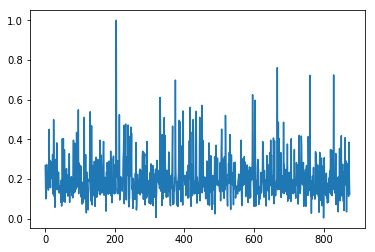

In [43]:
plt.plot(y_train)
plt.show()

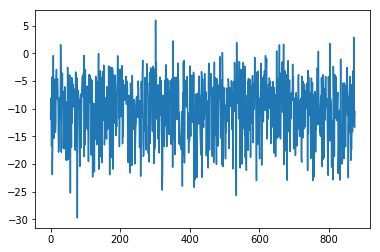

In [48]:
plt.plot(predictions)
plt.show()

## Training with Neural Networks and Regression